In [1]:
from tkinter import *
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import numpy as np

In [2]:
linestyle_str = [
     ('solid', 'solid'),      # Same as (0, ()) or '-'
     ('dotted', 'dotted'),    # Same as (0, (1, 1)) or '.'
     ('dashed', 'dashed'),    # Same as '--'
     ('dashdot', 'dashdot')]  # Same as '-.'

linestyle_tuple = [
     ('loosely dotted',        (0, (1, 10))),
     ('dotted',                (0, (1, 1))),
     ('densely dotted',        (0, (1, 1))),

     ('loosely dashed',        (0, (5, 10))),
     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),

     ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

In [14]:
def utility_compare_uniform(Hstore, Honline, Lstore, Lonline):
    if max(Lstore, Lonline) >= 0 and max(Hstore, Honline) >= 0:
        if Lstore > Lonline:
            return "BS"
        else:
            return "BO"

    elif max(Lstore, Lonline) >= 0 and max(Hstore, Honline) < 0:
        if Lstore > Lonline:
            return "LS"
        else:
            return "LO"

    elif max(Lstore, Lonline) < 0 and max(Hstore, Honline) >= 0:
        if Hstore > Honline:
            return "HS"
        else:
            return "HO"

    elif max(Lstore, Lonline) < 0 and max(Hstore, Honline) < 0:
        return "No sales"
    else:
        raise Exception("other cases")


def utility_compare_dual(Hstore, Honline, Hshowrooming, Lstore, Lonline, Lshowrooming):
    # due to the the comparison between the three cases is independent of theta, we have:
    if Honline >= max(Hstore, Hshowrooming, 0):  # also implies Honline >= max(Hstore, Hshowrooming)
        if Lonline >= 0:
            return "BO"
        else:
            return "HO"
    elif Hstore >= max(Hshowrooming, 0):
        if Lstore >= 0:
            return "BS"
        else:
            return "HS"

    elif Hshowrooming >= 0:
        if Lshowrooming >= 0:
            return "BSR"
        else:
            return "HSR"
    elif max(Lstore, Lshowrooming, Lonline) < 0:
        return "NoSales"
    else:
        raise Exception("Other cases occur!")


class NumSolver:
    def __init__(self, V=0.8, GAMMA=0.2, P_HAT=0.1, DELTA_h=0.6, DELTA_l=0.2, CR=0.7):
        self.V = V
        self.GAMMA = GAMMA
        self.P_HAT = P_HAT
        self.DELTA_h = DELTA_h
        self.DELTA_l = DELTA_l
        self.CR = CR

    def get_utility(self, TYPE, p, poff, c, con):

        if p >= self.P_HAT:
            delta = self.DELTA_h
        else:
            delta = self.DELTA_l

        if TYPE == "H":
            theta = 1.00
        elif TYPE == "L":
            theta = self.V
        else:
            raise Exception("Consumer Type Error!")

        u_store = (theta - poff) / 2 - c
        u_online = (theta - 2 * p + delta * p) / 2 - con
        u_showrooming = (theta - p - con) / 2 - c

        u_store = int(u_store * 10000 + 0.5) / 10000
        u_online = int(u_online * 10000 + 0.5) / 10000
        u_showrooming = int(u_showrooming * 10000 + 0.5) / 10000

        return u_store, u_online, u_showrooming

    def get_profit(self, p, poff, c, con):

        if p >= self.P_HAT:
            delta = self.DELTA_h
        else:
            delta = self.DELTA_l

        H_u_store, H_u_online, H_u_showrooming = self.get_utility("H", p, poff, c, con)
        L_u_store, L_u_online, L_u_showrooming = self.get_utility("L", p, poff, c, con)

        # High type
        pi_H_showrooming = 1 / 4 * self.GAMMA * p * (
            [1 if (H_u_showrooming >= 0 and H_u_showrooming > max(H_u_store, H_u_online)) else 0][0])
        pi_H_store = 1 / 4 * self.GAMMA * poff * (
            [1 if (H_u_store >= max(H_u_showrooming, 0) and H_u_store > H_u_online) else 0][0])
        pi_H_online = 1 / 4 * self.GAMMA * (p + (1 - delta) * p - delta * self.CR) * (
            [1 if H_u_online >= max(H_u_showrooming, H_u_store, 0) else 0][0])

        # Low type
        pi_L_showrooming = 1 / 4 * (1 - self.GAMMA) * p * (
            [1 if (L_u_showrooming >= 0 and L_u_showrooming > max(L_u_store, L_u_online)) else 0][0])
        pi_L_store = 1 / 4 * (1 - self.GAMMA) * poff * (
            [1 if (L_u_store >= max(L_u_showrooming, 0) and L_u_store > L_u_online) else 0][0])
        pi_L_online = 1 / 4 * (1 - self.GAMMA) * (p + (1 - delta) * p - delta * self.CR) * (
            [1 if L_u_online >= max(L_u_showrooming, L_u_store, 0) else 0][0])

        expected_profit = pi_H_online + pi_H_store + pi_H_showrooming + pi_L_online + pi_L_store + pi_L_showrooming

        return expected_profit


class Run():
    def __init__(self, precision, PropShow,PropOffOnly):

        self.PropShow =PropShow

        self.PropOffOnly = PropOffOnly
        
        self.HighReturnProb = 0.5

        self.LowReturnProb =0.5

        self.PriceThreshold = 0.1
        
        self.ValLow = 0.5
        
        self.PropHigh = 0.25

        self.OnlineCost = 0.12
        
        self.ReturnCostRet = 0.2
        
        self.precision = precision
        
        self.res_dict = {}

        self.read_params()
        


    def plot_figures(self, ALPHA, BETA, V, GAMMA, P_HAT, DELTA_h, DELTA_l, CR, con, precision):
        self.solver = NumSolver(V, GAMMA, P_HAT, DELTA_h, DELTA_l, CR)

        optimal_profits_u = []
        optimal_prices_u = []

        optimal_profits_d = []
        optimal_prices_d = []

        behavior_tuples_both = []
        behavior_tuples_show = []
        behavior_tuples_off = []

        for current_c in np.arange(0, 0.35, precision):
            optimal_profit_u = 0
            optimal_price_u = 0
            optimal_profit_d = 0
            optimal_online_price_d = 0
            optimal_offline_price_d = 0

            for p_current in np.arange(0, 1, 0.005):
                profit_current_u = (1 - ALPHA - BETA) * self.solver.get_profit(p=p_current, poff=p_current, c=current_c,
                                                                               con=con) \
                                   + ALPHA * self.solver.get_profit(p=p_current, poff=p_current, c=current_c, con=0) \
                                   + BETA * self.solver.get_profit(p=p_current, poff=p_current, c=current_c, con=10)
                # find optimal uniform prices
                if profit_current_u > optimal_profit_u:
                    optimal_profit_u = profit_current_u
                    optimal_price_u = p_current

                # poff=pon+con, 1-alpha-beta segment does not conduct showrooming poff=V, 1-alpha-beta segment
                # conducts showrooming. The offline optimally serve all offline-only consumers poff=1, 1-alpha-beta
                # segment conducts showrooming. The offline optimally serve high type offline-only consumers
                OfflinePriceScenarios = [p_current + con]
                for poff_current in OfflinePriceScenarios:
                    profit_current_d = (1 - ALPHA - BETA) * self.solver.get_profit(p=p_current, poff=poff_current,
                                                                                   c=current_c, con=con) \
                                       + ALPHA * self.solver.get_profit(p=p_current, poff=poff_current, c=current_c, con=0) \
                                       + BETA * self.solver.get_profit(p=p_current, poff=poff_current, c=current_c, con=10)

                    if profit_current_d > optimal_profit_d:
                        optimal_profit_d = profit_current_d
                        optimal_online_price_d = p_current
                        optimal_offline_price_d = poff_current

            behavior_tuple_both = self.analyze_behavior(current_c, con, optimal_price_u, optimal_online_price_d,
                                                        optimal_offline_price_d)
            behavior_tuple_show = self.analyze_behavior(current_c, 0, optimal_price_u, optimal_online_price_d,
                                                       optimal_offline_price_d)
            behavior_tuple_off = self.analyze_behavior(current_c, 10, optimal_price_u, optimal_online_price_d,
                                                      optimal_offline_price_d)

            optimal_profits_u.append(optimal_profit_u)
            optimal_prices_u.append(optimal_price_u)
            optimal_profits_d.append(optimal_profit_d)
            optimal_prices_d.append((optimal_online_price_d, optimal_offline_price_d))
            behavior_tuples_both.append(behavior_tuple_both)
            behavior_tuples_show.append(behavior_tuple_show)
            behavior_tuples_off.append(behavior_tuple_off)
        
        for current_c, price_u, price_d, profit_u, profit_d in zip(
                np.arange(0, 0.35, precision), optimal_prices_u, optimal_prices_d, optimal_profits_u, optimal_profits_d):
            behavior_u_both, behavior_d_both = self.analyze_behavior(current_c, con, price_u, price_d[0], price_d[1])
            behavior_u_show, behavior_d_show = self.analyze_behavior(current_c, 0, price_u, price_d[0], price_d[1])
            behavior_u_off, behavior_d_off = self.analyze_behavior(current_c, 10, price_u, price_d[0], price_d[1])
            print("current c: {:.3f}, price_u: {:.3f}, price_d_on: {:.3f}, price_d_off: {:.3f}".format(
                current_c, price_u, price_d[0], price_d[1]))
            print("behavior of both-channel u:{}, d:{}".format(behavior_u_both, behavior_d_both))
            print("behavior of show u:{}, d:{}".format(behavior_u_show, behavior_d_show))
            print("behavior of off u:{}, d:{}".format(behavior_u_off, behavior_d_off))
            print("profit_u: {:.5f}, profit_d: {:.5f}".format(profit_u, profit_d))
        
#         fig1 = plt.figure(figsize=(8, 4.5))
#         ax1 = fig1.add_subplot(1, 1, 1)
#         ax1.plot(np.arange(0, 0.5, 0.01), optimal_profits_u, 'r', label="Uniform pricing",
#                  linestyle='dotted',linewidth=2)
#         ax1.plot(np.arange(0, 0.5, 0.01), optimal_profits_d, label="Dual pricing",
#                  linestyle='dashdot',linewidth=2)
#         ax1.set_ylabel("Profits", fontsize =16)
#         ax1.set_xlabel("c", fontsize =16)
#         #ax1.set_title("Profits", fontsize =16)
#        # ax1.grid(axis='y', color ='#666666',lw=0.25)
#         ax1.legend(prop=dict(size=9), frameon=False)
        
        
#         fig2 = plt.figure(figsize=(8, 4.5))
#         ax2 = fig2.add_subplot(1, 1, 1)
#         ax2.plot(np.arange(0, 0.5, 0.01), optimal_prices_u, 'r', label="Uniform pricing",
#                  linestyle='dotted',linewidth=2)
#         ax2.plot(np.arange(0, 0.5, 0.01), [x[0] for x in optimal_prices_d], 
#                  label="Online price in Dual pricing", linestyle="dashdot", linewidth=2)
#         ax2.plot(np.arange(0, 0.5, 0.01), [x[1] for x in optimal_prices_d], 
#                  label="Offline price in Dual pricing",linestyle="--" ,linewidth=2)
#         ax2.set_ylabel("Prices", fontsize =16)
#         ax2.set_xlabel("c", fontsize =16)
#         ax2.legend(prop=dict(size=9), frameon=False,loc=4)
#        # ax2.grid(axis='y', color ='#666666',lw=0.25)
        
#         ## adjust figures
#         ax1.set_xlim([0, 0.5])
#         ax1.set_ylim([0, 0.14])
#         ax1.axvline(x=0.12, ymin=0, ymax=1,linestyle = '-.',lw=0.5,color="black")
#         ax1.axvline(x=0.17, ymin=0, ymax=1,linestyle = '-.',lw=0.5,color="black")
#         ax1.axvline(x=0.23, ymin=0, ymax=1,linestyle = '-.',lw=0.5,color="black")
#         ax1.axvline(x=0.24, ymin=0, ymax=1,linestyle = '-.',lw=0.5,color="black")
#         ax1.text(0.13,0.1, 'zone 1')
#         ax1.annotate("zone 2", xy=(0.235, 0.1), xytext=(0.26, 0.1),arrowprops=dict(arrowstyle="<-"))
        
#         ax2.set_xlim([0,0.5])
#         ax2.set_ylim([0,0.8])
#         ax2.axvline(x=0.12, ymin=0, ymax=1,linestyle = '-.',lw=0.5,color="black")
#         ax2.axvline(x=0.17, ymin=0, ymax=1,linestyle = '-.',lw=0.5,color="black")
#         ax2.axvline(x=0.23, ymin=0, ymax=1,linestyle = '-.',lw=0.5,color="black")
#         ax2.axvline(x=0.24, ymin=0, ymax=1,linestyle = '-.',lw=0.5,color="black")
#         ax2.text(0.13,0.1, 'zone 1')
#         ax2.annotate("zone 2", xy=(0.235, 0.2), xytext=(0.26, 0.2),arrowprops=dict(arrowstyle="<-"))
        
#         # save figures
        
#         #fig1.savefig("./MR_PFT.pdf")
#        # fig2.savefig("./MR_PCE.pdf")
        
        plt.show()

        res_dict = {"profit_u": optimal_profits_u, "profit_d": optimal_profits_d,
                    "price_u": optimal_prices_u, "price_d": optimal_prices_d,
                    "behavior_both": behavior_tuples_both, "behavior_show": behavior_tuples_show,
                    "behavior_off": behavior_tuples_off}
        self.res_dict = res_dict

    def read_params(self):
        alpha = float(self.PropShow)
        beta = float(self.PropOffOnly)
        if alpha + beta > 1:
            raise Exception("alpha + beta should be less than 1")

        delta_h = float(self.HighReturnProb)
        delta_l = float(self.LowReturnProb)
        phat = float(self.PriceThreshold)
        V = float(self.ValLow)
        gamma = float(self.PropHigh)

        con = float(self.OnlineCost)
        cr = float(self.ReturnCostRet)

        data_dict = self.plot_figures(ALPHA=alpha, BETA=beta, V=V, GAMMA=gamma, P_HAT=phat, DELTA_h=delta_h,
                                      DELTA_l=delta_l, CR=cr, con=con ,precision=self.precision)

    def analyze_behavior(self, c, con, uniform_price, dual_online_price, dual_offline_price):
        H_u_store, H_u_online, _ = self.solver.get_utility("H", uniform_price, uniform_price, c, con)
        L_u_store, L_u_online, _ = self.solver.get_utility("L", uniform_price, uniform_price, c, con)
        behavior_uniform = utility_compare_uniform(H_u_store, H_u_online, L_u_store, L_u_online)

        H_d_store, H_d_online, H_d_showrooming = self.solver.get_utility("H", dual_online_price, dual_offline_price, c,
                                                                         con)
        L_d_store, L_d_online, L_d_showrooming = self.solver.get_utility("L", dual_online_price, dual_offline_price, c,
                                                                         con)

        behavior_dual = utility_compare_dual(H_d_store, H_d_online, H_d_showrooming, L_d_store, L_d_online,
                                             L_d_showrooming)

        return behavior_uniform, behavior_dual


In [ ]:
def obtain_subcase(alpha, beta,prec):
    
    prec=0.005
    num = Run(precision=prec,PropShow=alpha,PropOffOnly=beta)
    
    min_c_ind = list( np.arange(0, 0.35, prec)).index(num.OnlineCost)
    max_c_ind = list( np.arange(0, 0.35, prec)).index(0.165)
    print(min_c_ind,max_c_ind)
    
    sel_c = np.arange(0, 0.35, prec)[min_c_ind:max_c_ind]
    sel_prices_u = num.res_dict["price_u"][min_c_ind:max_c_ind]
    sel_prices_d = num.res_dict["price_d"][min_c_ind:max_c_ind]
    sel_profits_u = num.res_dict["profit_u"][min_c_ind:max_c_ind]
    sel_profits_d = num.res_dict["profit_d"][min_c_ind:max_c_ind]
    
    return sel_c,sel_prices_u，sel_prices_d,sel_profits_u,sel_profits_d

In [19]:
def show_result(alphas, betas,prec,flag=False):
    
    fig,axes = plt.subplots(2, len(alphas),sharex='col', sharey='row',figsize=fz)
    fig.subplots_adjust(hspace=0.6, wspace=0.4)
    
    for alpha, beta in zip(alphas, betas):
        print("---"*20)
        sel_c,sel_prices_u，sel_prices_d,sel_profits_u,sel_profits_d = obtain_subcase(alpha, beta,prec)
    
    fig1 = plt.figure(figsize=(8, 4.5))
    ax1 = fig1.add_subplot(1, 1, 1)
    ax1.plot(sel_c, sel_profits_u,c='red', ls='--', ms=4, marker='^', markerfacecolor='none', label="Uniform pricing")
    ax1.plot(sel_c, sel_profits_d, c='blue', ls='--', ms=4, marker='o',markerfacecolor='none', label="Dual pricing")

    ax1.set_ylabel("Profits", fontsize =16)
    ax1.set_xlabel("c", fontsize =16)
    #ax1.set_title("Profits", fontsize =16)
    # ax1.grid(axis='y', color ='#666666',lw=0.25)
    ax1.legend(prop=dict(size=9), frameon=False)


    fig2 = plt.figure(figsize=(8, 4.5))
    ax2 = fig2.add_subplot(1, 1, 1)
    ax2.plot(sel_c, sel_prices_u, c='red', ls='--', ms=4, marker='^', markerfacecolor='none',label="Uniform pricing")
    ax2.plot(sel_c, [x[0] for x in sel_prices_d], c='blue', ls='--', ms=4, marker='o',  markerfacecolor='none',label="Online price in Dual pricing")
    ax2.plot(sel_c, [x[1] for x in sel_prices_d],c='green',  ls='--', ms=4, marker='D',markerfacecolor='none',label="Offline price in Dual pricing")
    ax2.set_ylabel("Prices", fontsize =16)
    ax2.set_xlabel("c", fontsize =16)
    ax2.legend(prop=dict(size=9), frameon=False,loc=4)

current c: 0.000, price_u: 0.500, price_d_on: 0.380, price_d_off: 0.500
behavior of both-channel u:BS, d:BS
behavior of show u:BS, d:BSR
behavior of off u:BS, d:BS
profit_u: 0.12500, profit_d: 0.11900
current c: 0.005, price_u: 0.490, price_d_on: 0.370, price_d_off: 0.490
behavior of both-channel u:BS, d:BS
behavior of show u:BS, d:BSR
behavior of off u:BS, d:BS
profit_u: 0.12250, profit_d: 0.11650
current c: 0.010, price_u: 0.480, price_d_on: 0.360, price_d_off: 0.480
behavior of both-channel u:BS, d:BS
behavior of show u:BS, d:BSR
behavior of off u:BS, d:BS
profit_u: 0.12000, profit_d: 0.11400
current c: 0.015, price_u: 0.470, price_d_on: 0.350, price_d_off: 0.470
behavior of both-channel u:BS, d:BS
behavior of show u:BS, d:BSR
behavior of off u:BS, d:BS
profit_u: 0.11750, profit_d: 0.11150
current c: 0.020, price_u: 0.460, price_d_on: 0.340, price_d_off: 0.460
behavior of both-channel u:BS, d:BS
behavior of show u:BS, d:BSR
behavior of off u:BS, d:BS
profit_u: 0.11500, profit_d: 0.1

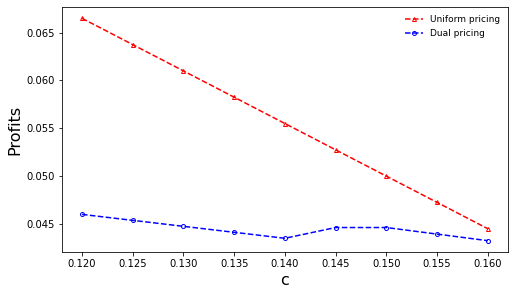

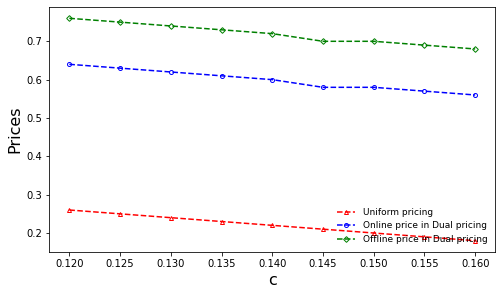

In [25]:
show_result(alpha=0.2, beta=0.2,prec=0.005)

In [ ]:

fig1.savefig("./MR_PFT.pdf")
fig2.savefig("./MR_PCE.pdf")
fig1.savefig("./MR_PFT.eps")
fig2.savefig("./MR_PCE.eps")

plt.show()